**BNB (Build and Build)**

**Project Title: FutureCoin: Machine Learning-Based Crypto Price Prediction**


**1. Project Statement and Outcomes:**

1.The Cryptocurrency Price Prediction Using Machine Learning project aims to predict future cryptocurrency prices using time-series forecasting. The system will preprocess historical data, build predictive models, and visualize trends to offer valuable insights into future price movements.

2.A system that accurately predicts future cryptocurrency prices using time-series forecasting. It will offer valuable insights into market trends by analyzing historical data and visualizing predicted price movements, helping users make informed decisions in the cryptocurrency market.

**Milestone 2:**

**Week 3-4: Modal Architecture, Training, Evaluation:**

● Identify and create relevant features for time-series forecasting (e.g., moving averages, rolling statistics).

● Train machine learning models for time-series forecasting to predict future prices.

● Tune hyperparameters and validate model performance using standard metrics like MSE and MAE.

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv("BNB_cleaned_scaled.csv")


In [7]:
df.columns


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Volume', 'Trades',
       'HL_PCT', 'PCT_change', 'Open Time'],
      dtype='object')

In [8]:
print(df.head())
print(df.shape)

       Open      High       Low     Close    Volume  Quote Volume    Trades  \
0  0.008439  0.012623  0.000000  0.013965  0.000391      0.000035  0.000504   
1  0.000000  0.006330  0.035088  0.011761  0.004914      0.000619  0.002125   
2  0.010367  0.002213  0.045855  0.007440  0.003997      0.000500  0.000413   
3  0.010371  0.007639  0.045557  0.013161  0.013731      0.001779  0.002033   
4  0.016072  0.007635  0.048245  0.010791  0.009009      0.001183  0.000886   

     HL_PCT  PCT_change                Open Time  
0  1.000000    0.654236  2017-11-06 03:00:00.000  
1  0.277957    0.962217  2017-11-06 04:00:00.000  
2  0.005926    0.348578  2017-11-06 05:00:00.000  
3  0.110784    0.549030  2017-11-06 06:00:00.000  
4  0.065153    0.272156  2017-11-06 07:00:00.000  
(8333, 10)


----- MODEL PERFORMANCE -----
R² Score : 0.9952654198837747
MAE      : 0.0012016444366248435
RMSE     : 0.0016038114520581786


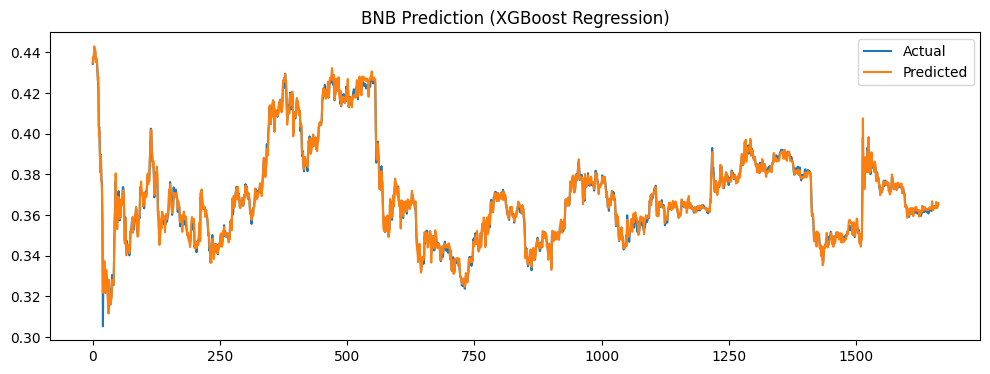

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import matplotlib.pyplot as plt

# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv("BNB_cleaned_scaled.csv")

# -----------------------------
# Ensure proper sorting (use Open Time)
# -----------------------------
df = df.sort_values("Open Time").reset_index(drop=True)

# -----------------------------
# Technical Indicators
# -----------------------------
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(period).mean()
    avg_loss = pd.Series(loss).rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df["RSI"] = compute_rsi(df["Close"])

# EMA
df["EMA_9"] = df["Close"].ewm(span=9, adjust=False).mean()
df["EMA_21"] = df["Close"].ewm(span=21, adjust=False).mean()

# Bollinger Bands
df["BB_MID"] = df["Close"].rolling(20).mean()
df["BB_UPPER"] = df["BB_MID"] + 2 * df["Close"].rolling(20).std()
df["BB_LOWER"] = df["BB_MID"] - 2 * df["Close"].rolling(20).std()

# Volatility
df["Volatility_20"] = df["Close"].rolling(20).std()

# Lag features
for lag in range(1, 25):
    df[f"Close_lag_{lag}"] = df["Close"].shift(lag)

df = df.dropna().reset_index(drop=True)

# -----------------------------
# Train/Test Split (80-20)
# -----------------------------
features = df.drop(["Close", "Open Time"], axis=1)
target = df["Close"]

split = int(0.8 * len(df))

X_train = features.iloc[:split]
X_test  = features.iloc[split:]
y_train = target.iloc[:split]
y_test  = target.iloc[split:]

# -----------------------------
# Scaling
# -----------------------------
sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# -----------------------------
# XGBoost Model
# -----------------------------
model = xgb.XGBRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror"
)

model.fit(X_train_scaled, y_train)

# -----------------------------
# Predictions
# -----------------------------
y_pred = model.predict(X_test_scaled)

# -----------------------------
# Metrics
# -----------------------------
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("----- MODEL PERFORMANCE -----")
print("R² Score :", r2)
print("MAE      :", mae)
print("RMSE     :", rmse)

# -----------------------------
# Plot Actual vs Predicted
# -----------------------------
plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("BNB Prediction (XGBoost Regression)")
plt.legend()
plt.show()


R² Score : 0.9952654198837747
MAE      : 0.0012016444366248435
RMSE     : 0.0016038114520581786


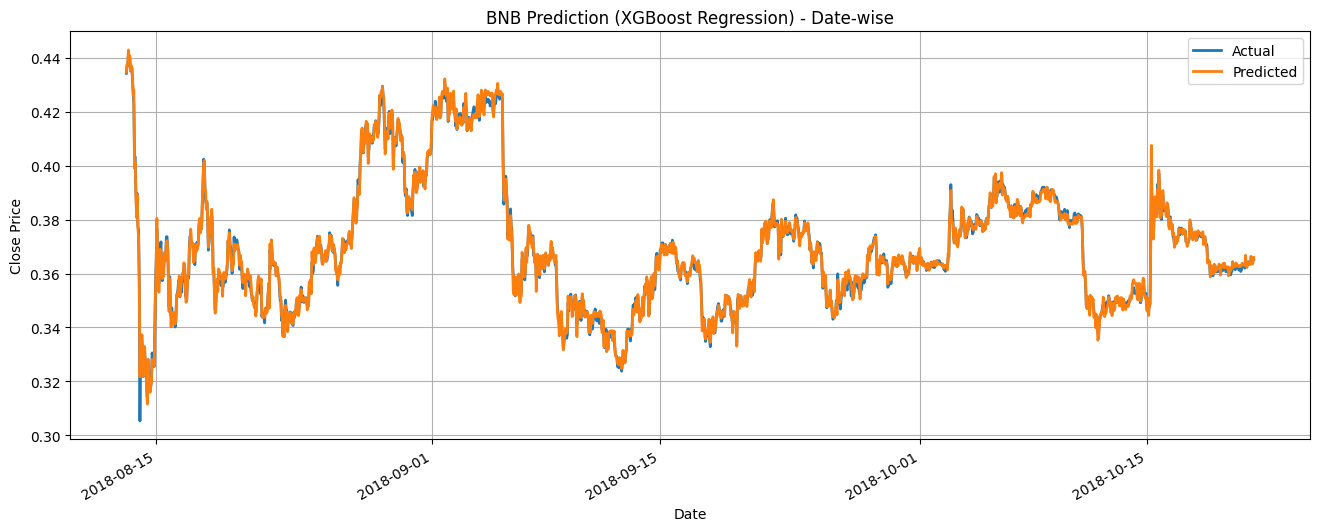

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import matplotlib.pyplot as plt

# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv("BNB_cleaned_scaled.csv")
df["Open Time"] = pd.to_datetime(df["Open Time"])
df = df.sort_values("Open Time").reset_index(drop=True)

# -----------------------------
# Technical Indicators
# -----------------------------
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(period).mean()
    avg_loss = pd.Series(loss).rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df["RSI"] = compute_rsi(df["Close"])
df["EMA_9"] = df["Close"].ewm(span=9, adjust=False).mean()
df["EMA_21"] = df["Close"].ewm(span=21, adjust=False).mean()
df["BB_MID"] = df["Close"].rolling(20).mean()
df["BB_UPPER"] = df["BB_MID"] + 2 * df["Close"].rolling(20).std()
df["BB_LOWER"] = df["BB_MID"] - 2 * df["Close"].rolling(20).std()
df["Volatility_20"] = df["Close"].rolling(20).std()

# Lag features
for lag in range(1, 25):
    df[f"Close_lag_{lag}"] = df["Close"].shift(lag)

df = df.dropna().reset_index(drop=True)

# -----------------------------
# Train/Test Split (80-20)
# -----------------------------
features = df.drop(["Close", "Open Time"], axis=1)
target = df["Close"]
split = int(0.8 * len(df))
X_train = features.iloc[:split]
X_test  = features.iloc[split:]
y_train = target.iloc[:split]
y_test  = target.iloc[split:]

# -----------------------------
# Scaling
# -----------------------------
sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# -----------------------------
# XGBoost Model
# -----------------------------
model = xgb.XGBRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror"
)
model.fit(X_train_scaled, y_train)

# -----------------------------
# Predictions & Metrics
# -----------------------------
y_pred = model.predict(X_test_scaled)
print("R² Score :", r2_score(y_test, y_pred))
print("MAE      :", mean_absolute_error(y_test, y_pred))
print("RMSE     :", np.sqrt(mean_squared_error(y_test, y_pred)))

# -----------------------------
# Date-wise Plot
# -----------------------------
test_dates = df["Open Time"].iloc[split:].reset_index(drop=True)
plt.figure(figsize=(16,6))
plt.plot(test_dates, y_test.values, label="Actual", linewidth=2)
plt.plot(test_dates, y_pred, label="Predicted", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("BNB Prediction (XGBoost Regression) - Date-wise")
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()
